In [2]:
# coding=utf-8
import cv2
import numpy as np
import time
import shutil
import os
import matplotlib.pylab as plt
from scipy.misc import imresize
from skimage import transform,data
# 导入Python的数据处理库pandas，相当于python里的excel
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

# 导入python绘图matplotlib
import matplotlib.pyplot as plt
import json
# 使用ipython的魔法方法，将绘制出的图像直接嵌入在notebook单元格中
%matplotlib inline

# 设置绘图大小
plt.style.use({'figure.figsize':(50,40)})

In [3]:
df = '../Datasets/Datasets2/BreCaHAD/groundTruth/Case_7-03.json'
with open(df) as f:
    TumorArea_list = json.load(f)
    TumorArea_list

In [4]:
X = []
Y = []
for i in range(len(TumorArea_list['tumor'])):
    X.append(TumorArea_list['tumor'][i]['x'])
    Y.append(TumorArea_list['tumor'][i]['y'])


In [5]:
if __name__ == "__main__":
    Img = cv2.imread('../Datasets/Datasets2/BreCaHAD/images/Case_7-03.tif')
    Img1 = cv2.imread('../Datasets/Datasets2/BreCaHAD/images/Case_7-03.tif')
    # Img = cv2.resize(im1, (256,256), interpolation=cv2.INTER_CUBIC)
    kernel_2 = np.ones((2, 2), np.uint8)  # 2x2的卷积核
    kernel_3 = np.ones((3, 3), np.uint8)  # 3x3的卷积核
    kernel_4 = np.ones((4, 4), np.uint8)  # 4x4的卷积核
    if Img is not None:  # 判断图片是否读入
        HSV = cv2.cvtColor(Img, cv2.COLOR_BGR2HSV)  # 把RGB图像转换为HSV格式

There are 37 potential tumor areas
Accuracy:  1.0


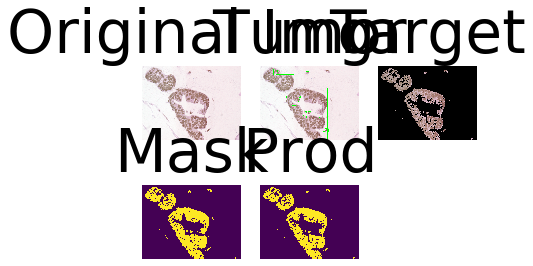

In [6]:
        '''
       HSV模型中颜色的参数分别是：色调（H），饱和度（S），明度（V）
      下面两个值是要识别的颜色范围2
        '''
        Lower = np.array([90, 25, 0])  # 要识别颜色的下限
        Upper = np.array([137, 255, 225])  # 要识别的颜色的上限
        # mask是把HSV图片中在颜色范围内的区域变成白色，其他区域变成黑色
        mask = cv2.inRange(HSV, Lower, Upper)
        # 下面四行是用卷积进行滤波
        erosion = cv2.erode(mask, kernel_4, iterations=1)
        erosion = cv2.erode(erosion, kernel_4, iterations=1)
        dilation = cv2.dilate(erosion, kernel_4, iterations=1)
        dilation = cv2.dilate(dilation, kernel_4, iterations=1)
        # target是把原图中的非目标颜色区域去掉剩下的图像
        target = cv2.bitwise_and(Img, Img, mask=dilation)
        # 将滤波后的图像变成二值图像放在binary中
        ret, binary = cv2.threshold(dilation, 127, 255, cv2.THRESH_BINARY)
        # 在binary中发现轮廓，轮廓按照面积从小到大排列
        contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        p = 0
        loc = [[0]*4 for i in range(len(contours))]
        for i in range(len(contours)):  # 遍历所有的轮廓
            x, y, w, h = cv2.boundingRect(contours[i])  # 将轮廓分解为识别对象的左上角坐标和宽、高
            
            loc[i] = [x,y,w,h]
            
            # 在图像上画上矩形（图片、左上角坐标、右下角坐标、颜色、线条宽度）
            cv2.rectangle(Img, (x, y), (x + w, y + h), (0, 255,), 2)
            # 给识别对象写上标号
            font = cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(Img, str(p), (x - 10, y + 10), font, 0.5, (0, 0, 255), 3)  # 加减10是调整字符位置
            p += 1
            
        print('There are', p, 'potential tumor areas')  # 终端输出目标数量
        
        ans = 0
        
        for i in range(len(TumorArea_list['tumor'])):
            for j in range(len(loc)):
                if TumorArea_list['tumor'][i]['x']<=loc[j][0]/1360+loc[j][2]/1360 and TumorArea_list['tumor'][i]['x']>=loc[j][0]/1360 and TumorArea_list['tumor'][i]['y']<=loc[j][1]/1024+loc[j][3]/1024 and TumorArea_list['tumor'][i]['y']>=loc[j][1]/1024:
                    ans += 1
                    break
                   
        
        print('Accuracy: ', ans/len(TumorArea_list['tumor']))
        
plt.subplot(2, 3, 1)
plt.imshow(Img1)
plt.title('Original Img', fontsize=60)
plt.axis('off')     

plt.subplot(2, 3, 2)
plt.imshow(Img)
plt.title('Tumor', fontsize=60)
plt.axis('off') 

plt.subplot(2, 3, 3)
plt.imshow(target)
plt.title('Target', fontsize=60)
plt.axis('off') 

plt.subplot(2, 3, 4)
plt.imshow(mask)
plt.title('Mask', fontsize=60)
plt.axis('off') 

plt.subplot(2, 3, 5)
plt.imshow(dilation)
plt.title('Prod', fontsize=60)
plt.axis('off') 

        #cv2.imshow('target', target)
        # cv2.imshow('Mask', mask)
        # cv2.imshow("prod", dilation)
        # cv2.imshow('Img', Img)
        # cv2.imwrite('Img.png', Img)  # 我秃了

In [ ]:
ans1 = 0
mis = 0
yellow = 0

for i in range(len(TumorArea_list['tumor'])):
    for j in range(len(dilation)):
        for z in range(len(dilation[1])):
            height = (j-1)/1024
            width = (z-1)/1360
            if dilation[j-1][z-1] == 255 and height-0.01 <= TumorArea_list['tumor'][i]['y'] <= height+0.012 and width-0.01 <= TumorArea_list['tumor'][i]['x'] <= width+0.01:
                yellow += 1
                ans1 += 1
                break
            elif dilation[j-1][z-1] == 255 and height-0.04 <= TumorArea_list['tumor'][i]['y'] <= height+0.04 and width-0.04 <= TumorArea_list['tumor'][i]['x'] <= width+0.04:
                    yellow += 1
                    mis += 1
                    break
            elif dilation[j-1][z-1] == 255:
                if height != TumorArea_list['tumor'][i]['y'] or width != TumorArea_list['tumor'][i]['x']:
                    yellow += 1
                    mis += 1
                    break
print(ans1)
print(mis)
accuracy = ans1/len(TumorArea_list['tumor'])
sensation = mis/1360/1024
print(accuracy)
print(sensation)
                